## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
BASE_DIR = "/kaggle/input/flicker-8k-image-dataset-captionstxt"
WORKING_DIR = "/kaggle/working"

## Extract Image Features

In [3]:
# load vgg16 models
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summerize 
print(model.summary())

2022-07-27 03:46:30.877472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 03:46:31.003298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 03:46:31.004077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 03:46:31.005672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# Extract features from image
features = {}
directory = os.path.join(BASE_DIR, "Images")

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224,224)) # Loading & Resizing the image
    # Convert image pixel to numpy array
    image = img_to_array(image)
    # reshaping data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    #Extract features
    feature = model.predict(image, verbose=0)
    # Get Image ID
    image_id = img_name.split(".")[0]
    # store features
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2022-07-27 03:46:37.765680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-27 03:46:38.892835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, "features.pkl"), "wb"))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, "features.pkl"),"rb") as f:
    features = pickle.load(f)

## Load the captions Data

In [7]:
with open(os.path.join(BASE_DIR, "captions.txt"), "r") as f:
    next(f)
    captions_doc = f.read()

In [8]:
#captions_doc

In [9]:
# Create mapping of images to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split("\n")):
    # split the line by comma()
    tokens = line.split(".")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    # Remove extention from image ID
    image_id = image_id.split(".")[0]
    # Convert caption list to string
    caption = " ".join(caption)
    # Create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

## Image Preprocessing

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # delete digits, special chars etc
            caption = caption.replace("[^A-Za-z]","")
            # delete additional spaces
            caption = caption.replace("\s+"," ")
            caption = caption.replace("jpg"," ")
            
            # Add start & end tags to the caption
            caption = "<start>" + " ".join([word for word in caption.split() if len(word)>1]) + "<end>"
            captions[i] = caption

In [12]:
# Before preprocess of text
mapping["1000268201_693b08cb0e"]

['jpg,A child in a pink dress is climbing up a set of stairs in an entry way  ',
 'jpg,A girl going into a wooden building  ',
 'jpg,A little girl climbing into a wooden playhouse  ',
 'jpg,A little girl climbing the stairs to her playhouse  ',
 'jpg,A little girl in a pink dress going into a wooden cabin  ']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# After preprocess
mapping["1000268201_693b08cb0e"]

['<start>,a child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>,a girl going into wooden building<end>',
 '<start>,a little girl climbing into wooden playhouse<end>',
 '<start>,a little girl climbing the stairs to her playhouse<end>',
 '<start>,a little girl in pink dress going into wooden cabin<end>']

In [15]:
all_captions = [] # store in single list
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption) # entire list of captions

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['<start>,a child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>,a girl going into wooden building<end>',
 '<start>,a little girl climbing into wooden playhouse<end>',
 '<start>,a little girl climbing the stairs to her playhouse<end>',
 '<start>,a little girl in pink dress going into wooden cabin<end>',
 '<start>,a black dog and spotted dog are fighting<end>',
 '<start>,a black dog and tri-colored dog playing with each other on the road<end>',
 '<start>,a black dog and white dog with brown spots are staring at each other in the street<end>',
 '<start>,two dogs of different breeds looking at each other on the road<end>',
 '<start>,two dogs on pavement moving toward each other<end>']

In [18]:
# Tokonize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8477

In [20]:
# get maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

## Train_Test_Split

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# Create data generator to get data in batch( avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each captions
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0] #[for each word we will be assigning a index]
                # split the sequence int X, y piars
                for i in range(1,len(seq)):
                    # split into input & output pairs
                    in_seq, out_seq =seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2],y
                X1, X2 , y= list(), list(), list()
                n = 0
                

## Model Creation

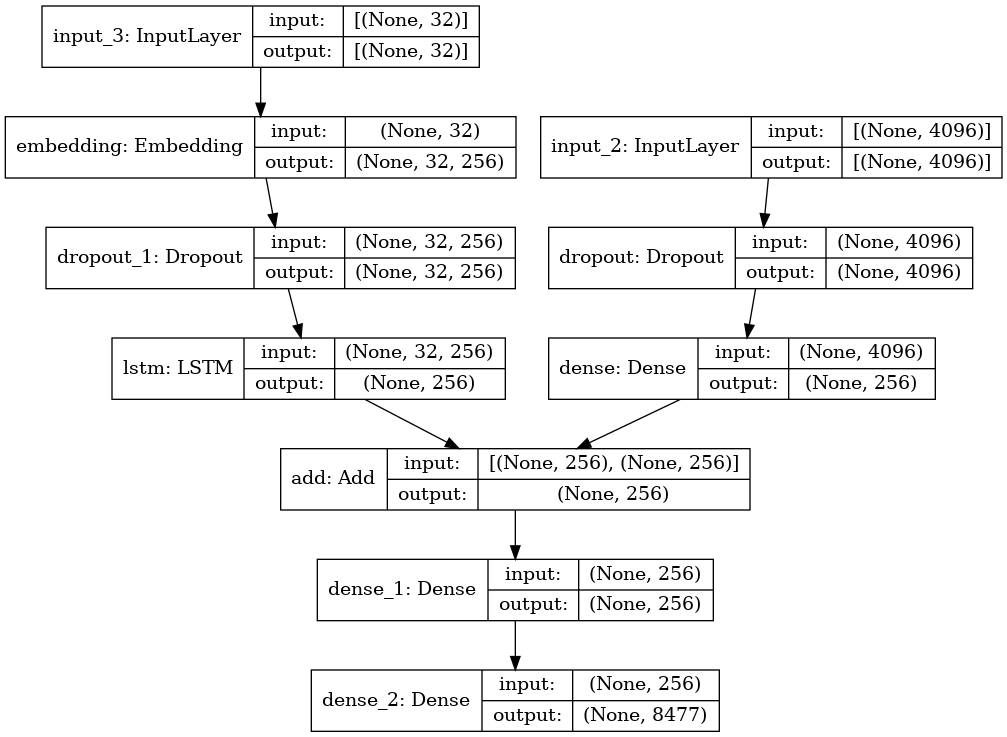

In [23]:
#image feature layers(encoder)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation="relu")(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation="relu")(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

model =Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="Adam")

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# Train the model
epochs = 15
batch_size = 64
steps = len(train)// batch_size

for i in range(epochs):
    # craete data generator
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    # fit for one epoch
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

113/113 [==============================] - 56s 492ms/step - loss: 2.4006


In [25]:
# save the model
model.save(WORKING_DIR+"/best_model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Generate Captions for the Images

In [26]:
def idx_to_word(integer, tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# Function for generating caption
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = "<start>"
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat =  model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word is not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text +=" "+ word
        # Stop if we reach end tag
        if word == "<end>":
            break
    return in_text
    
        
    

In [35]:
from nltk.translate.bleu_score import corpus_bleu
## Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred=y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.133633
BLEU-2: 0.070936


## Visualize the Results

In [37]:
from PIL import Image # for loading the image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # Load the image
    # image_name = "1002674143_1b742ab4b8.jpg"
    image_id = image_name.split(".")[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("---------------------Actual---------------------")
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("---------------------Predicted-------------------")
    print(y_pred)
    plt.imshow(image)


---------------------Actual---------------------
<start>,a little girl covered in paint sits in front of painted rainbow with her hands in bowl<end>
<start>,a little girl is sitting in front of large painted rainbow<end>
<start>,a small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it<end>
<start>,there is girl with pigtails sitting in front of rainbow painting<end>
<start>,young girl with pigtails painting outside in the grass<end>
---------------------Predicted-------------------
<start> a girl in pink dress is sitting in the grass end of rainbow rainbow rainbow rainbow flowers end end end end end end end end end end end end end end end


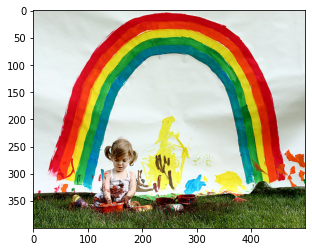

In [38]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
<start>,a black and white dog is running in grassy garden surrounded by white fence<end>
<start>,a black and white dog is running through the grass<end>
<start>,a boston terrier is running in the grass<end>
<start>,a boston terrier is running on lush green grass in front of white fence<end>
<start>,a dog runs on the green grass near wooden fence<end>
---------------------Predicted-------------------
<start> a boston terrier is running through the grass end end of the grass end end end end end end end end end end end end of the grass end end end end


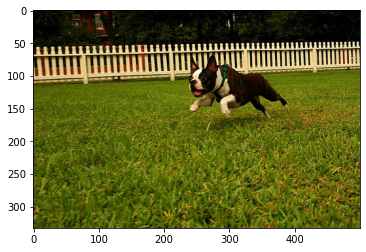

In [39]:
generate_caption("1009434119_febe49276a.jpg")

---------------------Actual---------------------
<start>,a boy smiles in front of stony wall in city<end>
<start>,a little boy is standing on the street while man in overalls is working on stone wall<end>
<start>,a young boy runs aross the street<end>
<start>,a young child is walking on stone paved street with metal pole and man behind him<end>
<start>,smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him<end>
---------------------Predicted-------------------
<start> a boy in red shirt is walking aross the street end of stony end end end end end end end end end end end end end end end end of stony wall


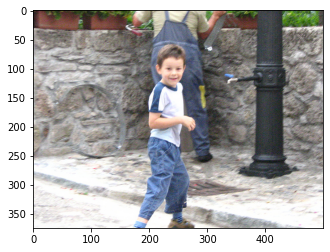

In [40]:
generate_caption("1015118661_980735411b.jpg")

---------------------Actual---------------------
<start>,a hiker standing high on bluff overlooking the mountains below<end>
<start>,a person on ski 's looks from hill over snow covered landscape<end>
<start>,a skier is overlooking snow-covered mountain<end>
<start>,a skier is overlooking the beautiful white snow covered landscape<end>
<start>,a skier pauses on mountaintop<end>
---------------------Predicted-------------------
<start> a skier is snowboarding down snowy hill end end end end of snowy landscape end end end end end end end end end end end end end end end end end end


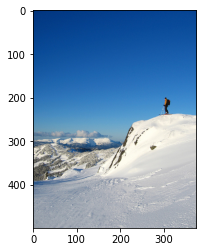

In [41]:
generate_caption("106514190_bae200f463.jpg")